## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 13:46:58--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.1s    

2021-10-04 13:46:59 (1.48 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [8]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


## Your code

What are the categorical variables? What are the numerical?

In [14]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['home', 'marital', 'records', 'job']

In [23]:
numerical = [x for x in df.columns.tolist() if x not in categorical and x != 'default']
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val  = train_test_split(df_full_train, test_size=0.25, random_state=1) # 25% here means it will be 20% of the overall data set

len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [21]:
from sklearn.metrics import roc_auc_score

In [108]:
scores = []

for var in numerical:
    auc = roc_auc_score(df_train['default'], df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(-df_train['default'], df_train[var])
    scores.append((var, auc))

In [109]:
scores

[('seniority', 0.7023678639081825),
 ('time', 0.5614152707102973),
 ('age', 0.5669245007366688),
 ('expenses', 0.5010232886379675),
 ('income', 0.6865223662543798),
 ('assets', 0.6348459805123252),
 ('debt', 0.5005076204979633),
 ('amount', 0.588419133578477),
 ('price', 0.5144145649939952)]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [35]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [36]:
def train(df, y_train):
    dicts = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [37]:
dv, model = train(df_train[features], df_train['default'])

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [56]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [57]:
y_pred = predict(df_val[features],dv, model)
roc_auc_score(df_val['default'], y_pred)

0.8120879813449298

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [68]:
import matplotlib.pyplot as plt

In [63]:
def precision_and_recall(y_val, y_pred):
    thresholds = np.linspace(0.0, 1.0, 100)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = false_negative = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        scores.append((t, p, r))
        
    columns = ['threshold', 'precision', 'recall']
    scores_df = pd.DataFrame(scores, columns=columns)

    return scores_df 

In [64]:
df_scores = precision_and_recall(df_val['default'], y_pred)
df_scores

/tmp/ipykernel_73/926410388.py:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


,threshold,precision,recall
0,0.000000,0.276094,1.00000
1,0.010101,0.279228,1.00000
2,0.020202,0.284714,0.99187
3,0.030303,0.290168,0.98374
4,0.040404,0.300621,0.98374
...,...,...,...
95,0.959596,NaN,0.00000
96,0.969697,NaN,0.00000
97,0.979798,NaN,0.00000
98,0.989899,NaN,0.00000


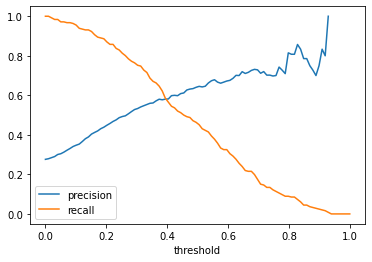

In [67]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision' )
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.xlabel('threshold')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [69]:
def f1_score(y_val, y_pred):
    thresholds = np.linspace(0.0, 1.0, 100)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = false_negative = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        f1_score = 2 * (p * r) / (p + r)
        
        scores.append((t, f1_score))
        
    columns = ['threshold', 'f1_score']
    scores_df = pd.DataFrame(scores, columns=columns)

    return scores_df 

In [76]:
f1_scores = f1_score(df_val['default'], y_pred)
max_idx = f1_scores['f1_score'].idxmax()
f1_scores.iloc[max_idx]

/tmp/ipykernel_73/2436978438.py:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


threshold    0.313131
f1_score     0.627986
Name: 31, dtype: float64

At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [77]:
from sklearn.model_selection import KFold

In [89]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [90]:
def train(df, y_train):
    dicts = df[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [91]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [92]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['default'].values
    y_val = df_val['default'].values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

In [93]:
scores

[0.8256212256212256,
 0.8254077031563474,
 0.789298525308888,
 0.8153421373265731,
 0.8054696294614563]

In [94]:
import statistics

In [95]:
res = statistics.pstdev(scores)
res

0.013669069470482898

How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [96]:
c_values = [0.01, 0.1, 1, 10]

In [97]:
def train(df, y_train, C):
    dicts = df[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [111]:
def evaluate_c(C):
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['default'].values
        y_val = df_val['default'].values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    return scores

In [114]:
c_scores = []

for c in c_values:
    scores = evaluate_c(c)
    std = statistics.pstdev(scores)
    mean = statistics.mean(scores)
    c_scores.append((c, scores, std, mean))

columns = ['C', 'auc', 'std', 'mean']
scores_df = pd.DataFrame(c_scores, columns=columns)
scores_df

,C,auc,std,mean
0,0.01,"[0.8204138204138203, 0.8206702024114575, 0.788...",0.012552,0.808555
1,0.10,"[0.8232947232947232, 0.8252785888802813, 0.789...",0.013741,0.812902
2,1.00,"[0.8256212256212256, 0.8254077031563474, 0.789...",0.013669,0.812228
3,10.00,"[0.8255915255915256, 0.825427566891127, 0.7892...",0.014614,0.814143


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [115]:
max_idx = scores_df['mean'].idxmax()
scores_df.iloc[max_idx]

C                                                    10.0
auc     [0.8255915255915256, 0.825427566891127, 0.7892...
std                                              0.014614
mean                                             0.814143
Name: 3, dtype: object

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.